## Load packages

In [1]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

## Function to load data

In [2]:
def parse_telecom_data(filename_train,filename_test):
    '''
    Takes filename and returns X and Y after applying label encoding and OneHotEncoding

    Input:
        filename: name of CSV file to read
    Output:
        X: nparray of X data
        Y: nparray of labels
    '''
    X_train_in = pd.read_csv(filename_train)
    X_test_in = pd.read_csv(filename_test)
    ID_test = X_test_in[['customerID']].to_numpy()

    # get X with categorical data
    X_train_cat = X_train_in.drop(columns=['customerID','tenure','MonthlyCharges','TotalCharges','Discontinued'])
    X_test_cat = X_test_in.drop(columns=['customerID','tenure','MonthlyCharges','TotalCharges'])

    # get X with numeric data
    X_train_num = X_train_in[['tenure','MonthlyCharges']].to_numpy()
    X_test_num = X_test_in[['tenure','MonthlyCharges']].to_numpy()

    # get Y
    Y_train_cat = X_train_in.filter(['Discontinued'])

    # convert labels to numeric using LabelEncoder
    le = preprocessing.LabelEncoder()
    colList = X_train_cat.columns
    ncol_le = len(colList)
    m_train_rows = X_train_cat.shape[0]
    m_test_rows = X_test_cat.shape[0]
    X_train_le = np.zeros((m_train_rows,ncol_le))
    X_test_le = np.zeros((m_test_rows,ncol_le))
    for jdx in range(0,ncol_le):
        le.fit(X_train_cat[colList[jdx]])
        X_train_le[:,jdx] = le.transform(X_train_cat[colList[jdx]])
        X_test_le[:,jdx] = le.transform(X_test_cat[colList[jdx]])
    
    # get labels for training data
    Y_train = Y_train_cat.apply(le.fit_transform)
    Y_train = Y_train.to_numpy()

    # use OneHotEncoder (applied to encoded labels)
    enc = preprocessing.OneHotEncoder()
    enc.fit(X_train_le)
    X_train_ohl = enc.transform(X_train_le).toarray()
    X_test_ohl = enc.transform(X_test_le).toarray()

    # combine data
    n_ohl = X_train_ohl.shape[1]
    n_num = X_train_num.shape[1]
    X_train = np.zeros((m_train_rows,n_ohl+n_num))
    X_test = np.zeros((m_test_rows,n_ohl+n_num))
    X_train[:,0:n_ohl] = X_train_ohl
    X_test[:,0:n_ohl] = X_test_ohl
    X_train[:,n_ohl:] = X_train_num
    X_test[:,n_ohl:] = X_test_num

    return X_train,Y_train,X_test,ID_test

In [57]:
def parse_telecom_data_fillna(filename_train,filename_test):
    '''
    Takes filename and returns X and Y after applying label encoding and OneHotEncoding

    Input:
        filename: name of CSV file to read
    Output:
        X: nparray of X data
        Y: nparray of labels
    '''
    X_train_in = pd.read_csv(filename_train)
    X_test_in = pd.read_csv(filename_test)
    ID_test = X_test_in[['customerID']].to_numpy()

    # get X with categorical data

    X_train_in.fillna(-1, inplace=True)
    X_test_in.fillna(-1, inplace=True)
    X_train_cat = X_train_in.drop(columns=['customerID','tenure','MonthlyCharges','TotalCharges','Discontinued'])
    X_test_cat = X_test_in.drop(columns=['customerID','tenure','MonthlyCharges','TotalCharges'])

    # get X with numeric data
    X_train_num = X_train_in[['tenure','MonthlyCharges','TotalCharges']].to_numpy()
    X_test_num = X_test_in[['tenure','MonthlyCharges','TotalCharges']].to_numpy()

    # get Y
    Y_train_cat = X_train_in.filter(['Discontinued'])

    # convert labels to numeric using LabelEncoder
    le = preprocessing.LabelEncoder()
    colList = X_train_cat.columns
    ncol_le = len(colList)
    m_train_rows = X_train_cat.shape[0]
    m_test_rows = X_test_cat.shape[0]
    X_train_le = np.zeros((m_train_rows,ncol_le))
    X_test_le = np.zeros((m_test_rows,ncol_le))
    for jdx in range(0,ncol_le):
        le.fit(X_train_cat[colList[jdx]])
        X_train_le[:,jdx] = le.transform(X_train_cat[colList[jdx]])
        X_test_le[:,jdx] = le.transform(X_test_cat[colList[jdx]])
    
    # get labels for training data
    Y_train = Y_train_cat.apply(le.fit_transform)
    Y_train = Y_train.to_numpy()

    # use OneHotEncoder (applied to encoded labels)
    enc = preprocessing.OneHotEncoder()
    enc.fit(X_train_le)
    X_train_ohl = enc.transform(X_train_le).toarray()
    X_test_ohl = enc.transform(X_test_le).toarray()

    # combine data
    n_ohl = X_train_ohl.shape[1]
    n_num = X_train_num.shape[1]
    X_train = np.zeros((m_train_rows,n_ohl+n_num))
    X_test = np.zeros((m_test_rows,n_ohl+n_num))
    X_train[:,0:n_ohl] = X_train_ohl
    X_test[:,0:n_ohl] = X_test_ohl
    X_train[:,n_ohl:] = X_train_num
    X_test[:,n_ohl:] = X_test_num

    return X_train,Y_train,X_test,ID_test

## Load Data

In [3]:
# get data
[X_train,Y_train,X_test,ID_test] = parse_telecom_data(filename_train='train.csv',filename_test='test.csv');

# check for NaN
if np.isnan(X_train).any():
    print('NaN in training data');
if np.isnan(X_test).any():
    print('NaN in test data');

## EDA

In [33]:
X_train_in = pd.read_csv('train.csv')
X_test_in = pd.read_csv('test.csv')

In [34]:
Y_train

array([[1],
       [0],
       [1],
       ...,
       [1],
       [0],
       [1]])

In [35]:
X_train_in.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Discontinued
0,1915-IOFGU,Female,0,No,No,1,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,No,Electronic check,70.50,70.50,Yes
1,6728-CZFEI,Female,0,No,No,15,Yes,No,DSL,No,...,No,No,Yes,No,One year,No,Mailed check,56.15,931.90,No
2,3863-IUBJR,Male,0,Yes,Yes,12,Yes,No,DSL,No,...,No,No,No,Yes,One year,No,Credit card (automatic),53.65,696.35,Yes
3,5572-ZDXHY,Female,0,No,No,22,Yes,No,Fiber optic,No,...,No,No,No,Yes,Month-to-month,Yes,Mailed check,84.30,1855.65,Yes
4,8348-HFYIV,Male,0,No,No,2,No,No phone service,DSL,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,49.25,90.35,Yes


In [ ]:
X_train.shape

## Train Decision Tree Classifier

In [ ]:
clf = RandomForestClassifier(n_estimators = 1000,criterion='gini');
#clf = DecisionTreeClassifier(criterion='gini');
clf.min_samples_leaf = 50;
clf.fit(X_train,Y_train.flatten());

## Compute metric for training data

In [ ]:
y_train_prob = clf.predict_proba(X_train);
thisMetric = metrics.roc_auc_score(Y_train, y_train_prob[:,1]);
print("Training metric: ",thisMetric)

## Save test prediction to CSV

In [ ]:
y_test_prob = clf.predict_proba(X_test);
thisData = np.concatenate((ID_test, np.reshape(y_test_prob[:,1],(-1,1))), axis=1);
thisLabel = ['ID','TARGET'];
y_test_prob_pd = pd.DataFrame(data=thisData,columns=thisLabel)
fname_submit = 'test_submission.csv';
y_test_prob_pd.to_csv(fname_submit,index=False);

## Neural Network

### Init Neural Network Structure

In [ ]:
print(X_train.shape)
print(Y_train.shape)

In [ ]:
# set batch size
batch_size = 32

# Prepare dataset using DataLoader
class telecomDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
# create dataset
# split training data into training and validation
N_train = int(X_train.shape[0] * 4 / 5)
print('Number of training data is ',N_train)
X_train_train = X_train[0:N_train,:]
X_train_val = X_train[N_train:,:]
Y_train_train = Y_train[0:N_train]
Y_train_val = Y_train[N_train:]

# create training dataset
train_dataset = telecomDataset(torch.tensor(X_train_train).float(), torch.tensor(Y_train_train).float())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# create testing dataset
test_dataset = telecomDataset(torch.tensor(X_train_val).float(), torch.tensor(Y_train_val).float())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print(f'{len(train_loader)} training batches')
print(f'{len(train_loader) * batch_size} training samples')
print(f'{len(test_loader)} validation batches')

In [ ]:
import torch.nn as nn

model = nn.Sequential(
    
    # nn.Flatten(),
    nn.Linear(45, 64),
    nn.ReLU(),

    nn.Linear(64, 128),
    nn.ReLU(),

    nn.Dropout(0.5),

    nn.Linear(128, 256),
    nn.ReLU(),

    nn.Linear(256, 256),
    nn.ReLU(),

    nn.Dropout(0.5),

    nn.Linear(256, 64),
    nn.ReLU(),

    nn.Linear(64, 32),
    nn.ReLU(),

    nn.Linear(32, 1),

    nn.Sigmoid()
    # PyTorch implementation of cross-entropy loss includes softmax layer
)

In [ ]:
for p in model.parameters():
    print(p.data.shape)

In [ ]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
n_epochs = 100

# store metrics
training_accuracy_history = np.zeros([n_epochs, 1])
training_loss_history = np.zeros([n_epochs, 1])
validation_accuracy_history = np.zeros([n_epochs, 1])
validation_loss_history = np.zeros([n_epochs, 1])

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}/10:', end='')
    train_total = 0
    train_correct = 0
    # train
    model.train()
    for i, data in enumerate(train_loader):
        images, labels = data
        optimizer.zero_grad()
        # forward pass
        output = model(images)
        # calculate categorical cross entropy loss
        loss = criterion(output, labels)
        # backward pass
        loss.backward()
        optimizer.step()
        
        # track training accuracy
        output = (output > 0.5).float()
        train_total += labels.size(0)
        train_correct += (output == labels).sum().item()
        # track training loss
        training_loss_history[epoch] += loss.item()
        # progress update after 180 batches (~1/10 epoch for batch size 32)
        if i % 180 == 0: print('.',end='')
    training_loss_history[epoch] /= len(train_loader)
    training_accuracy_history[epoch] = train_correct / train_total
    print(f'\n\tloss: {training_loss_history[epoch,0]:0.4f}, acc: {training_accuracy_history[epoch,0]:0.4f}',end='')
        
    # validate
    test_total = 0
    test_correct = 0
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(test_loader):
            images, labels = data
            # forward pass
            output = model(images)
            # find accuracy
            output = (output > 0.5).float()
            test_total += labels.size(0)
            test_correct += (output == labels).sum().item()
            # find loss
            loss = criterion(output, labels)
            validation_loss_history[epoch] += loss.item()
        validation_loss_history[epoch] /= len(test_loader)
        validation_accuracy_history[epoch] = test_correct / test_total
    print(f', val loss: {validation_loss_history[epoch,0]:0.4f}, val acc: {validation_accuracy_history[epoch,0]:0.4f}')

In [ ]:
model.eval()
y_train_prob = model(torch.from_numpy(X_train).float()).detach().numpy()
thisMetric = metrics.roc_auc_score(Y_train, y_train_prob);
print("Training metric: ",thisMetric)

In [ ]:
model.eval()
y_test_prob = model(torch.from_numpy(X_test).float()).detach().numpy()
thisData = np.concatenate((ID_test, np.reshape(y_test_prob[:],(-1,1))), axis=1)
thisLabel = ['ID','TARGET']
y_test_prob_pd = pd.DataFrame(data=thisData,columns=thisLabel)
fname_submit = 'test_submission_Wei.csv'
y_test_prob_pd.to_csv(fname_submit,index=False)

## Adaboost

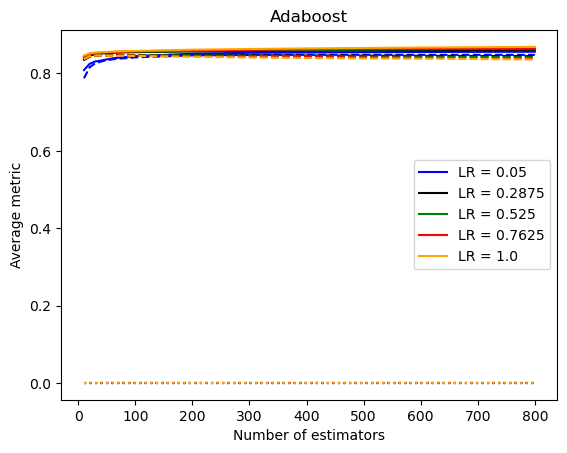

In [281]:
# AdaBoost case study
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True)    

n_est_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800]
learn_rate_list = np.linspace(0.05,1,5)
c = ['b', 'k', 'g', 'r', 'orange']

fig, ax = plt.subplots()

for i,lr in enumerate(learn_rate_list):
    avg_train_metric = np.zeros((len(n_est_list),))
    avg_val_metric = np.zeros((len(n_est_list),))
    avg_full_metric = np.zeros((len(n_est_list),))
    for j,n_est in enumerate(n_est_list):
        train_Metric = 0
        val_Metric = 0
        y_train_prob_avg = 0

        for train_idx, val_idx in kf.split(X_train[:,0]):
            x_train, x_val = X_train[train_idx,:], X_train[val_idx,:]
            y_train, y_val = Y_train[train_idx], Y_train[val_idx]

            clf = AdaBoostClassifier(n_estimators=n_est, learning_rate=lr)
            clf.fit(x_train, y_train.flatten())
            
            y_train_prob = clf.predict_proba(x_train)
            thisMetric = metrics.roc_auc_score(y_train, y_train_prob[:,1])
            train_Metric += thisMetric

            y_train_prob = clf.predict_proba(x_val)
            thisMetric = metrics.roc_auc_score(y_val, y_train_prob[:,1])
            val_Metric += thisMetric

            y_train_prob = clf.predict_proba(X_train)
            y_train_prob_avg += y_train_prob[:,1]

        avg_train_metric[j] = train_Metric/n_folds
        avg_val_metric[j] = val_Metric/n_folds
        avg_full_metric[j] = metrics.roc_auc_score(Y_train, y_train_prob_avg/n_folds)

    ax.plot(n_est_list,avg_train_metric, color=c[i], label=f'LR = {lr}')
    ax.plot(n_est_list,avg_val_metric, color=c[i], linestyle='--')
    ax.plot(n_est_list,avg_full_metric, color=c[i], linestyle=':')
    ax.set_xlabel('Number of estimators')
    ax.set_ylabel('Average metric')
    plt.title('Adaboost')

plt.legend()
plt.show()



In [275]:
n_folds = 5
kf = KFold(n_splits=n_folds)    
i = 0
train_Metric = 0
val_Metric = 0
y_train_prob_avg = 0
y_test_prob_avg = 0

for train_idx, val_idx in kf.split(X_train[:,0]):
    print(f'--------------- k-fold {i} ---------------')
    x_train, x_val = X_train[train_idx,:], X_train[val_idx,:]
    y_train, y_val = Y_train[train_idx], Y_train[val_idx]

    clf = AdaBoostClassifier(n_estimators=200, learning_rate=0.75);
    clf.fit(x_train, y_train.flatten());
    
    y_prob = clf.predict_proba(x_train);
    thisMetric = metrics.roc_auc_score(y_train, y_prob[:,1]);
    train_Metric += thisMetric
    print("Training metric: ",thisMetric)

    y_prob = clf.predict_proba(x_val);
    thisMetric = metrics.roc_auc_score(y_val, y_prob[:,1]);
    val_Metric += thisMetric
    print("Testing metric: ",thisMetric)

    y_train_prob = clf.predict_proba(X_train);
    y_train_prob_avg += y_train_prob[:,1]

    y_test_prob = clf.predict_proba(X_test);
    y_test_prob_avg += y_test_prob[:,1]
    print(' ')

    i += 1

print(f'Average training metric: {train_Metric/n_folds}')
print(f'Average testing metric: {val_Metric/n_folds}')
thisMetric = metrics.roc_auc_score(Y_train, y_train_prob_avg/n_folds);
print(f'Full training metric: {thisMetric}')

y_test_prob = y_test_prob_avg/n_folds
thisData = np.concatenate((ID_test, np.reshape(y_test_prob,(-1,1))), axis=1);
thisLabel = ['ID','TARGET'];
y_test_prob_pd = pd.DataFrame(data=thisData,columns=thisLabel)
fname_submit = 'test_submission_Ethan.csv';
y_test_prob_pd.to_csv(fname_submit,index=False);
    

--------------- k-fold 0 ---------------
Training metric:  0.8645440107062158
Testing metric:  0.8417018680183985
 
--------------- k-fold 1 ---------------
Training metric:  0.858586680223691
Testing metric:  0.8585885395399484
 
--------------- k-fold 2 ---------------
Training metric:  0.8627474778446377
Testing metric:  0.8410313522549439
 
--------------- k-fold 3 ---------------
Training metric:  0.8669388406949441
Testing metric:  0.8276242275079045
 
--------------- k-fold 4 ---------------
Training metric:  0.8591320696059843
Testing metric:  0.854874256626232
 
Average training metric: 0.8623898158150947
Average testing metric: 0.8447640487894855
Full training metric: 0.8598836430998116


## Gradient Boosting

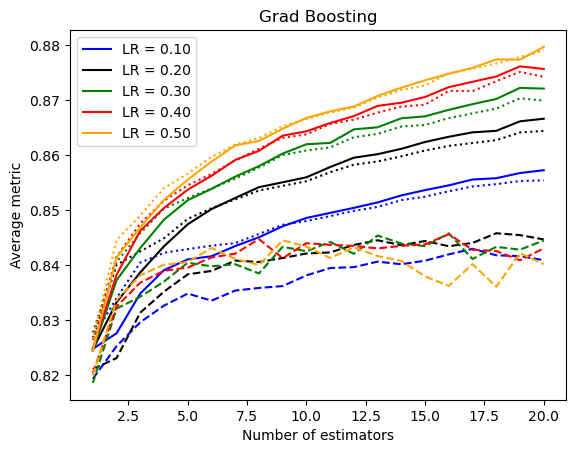

In [287]:
# Grad boosting case study
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True)    

n_est_list = np.linspace(1,20,20, dtype='int')
learn_rate_list = np.linspace(0.1,0.5,5)
c = ['b', 'k', 'g', 'r', 'orange']

fig, ax = plt.subplots()

for i,lr in enumerate(learn_rate_list):
    avg_train_metric = np.zeros((len(n_est_list),))
    avg_val_metric = np.zeros((len(n_est_list),))
    avg_full_metric = np.zeros((len(n_est_list),))
    for j,n_est in enumerate(n_est_list):
        train_Metric = 0
        val_Metric = 0
        y_train_prob_avg = 0
        for train_idx, val_idx in kf.split(X_train[:,0]):
            x_train, x_val = X_train[train_idx,:], X_train[val_idx,:]
            y_train, y_val = Y_train[train_idx], Y_train[val_idx]

            clf = GradientBoostingClassifier(n_estimators=n_est, learning_rate=lr);
            clf.fit(x_train, y_train.flatten());
            
            y_train_prob = clf.predict_proba(x_train);
            thisMetric = metrics.roc_auc_score(y_train, y_train_prob[:,1]);
            train_Metric += thisMetric

            y_train_prob = clf.predict_proba(x_val);
            thisMetric = metrics.roc_auc_score(y_val, y_train_prob[:,1]);
            val_Metric += thisMetric
            
            y_train_prob = clf.predict_proba(X_train);
            y_train_prob_avg += y_train_prob[:,1]

        avg_train_metric[j] = train_Metric/n_folds
        avg_val_metric[j] = val_Metric/n_folds
        avg_full_metric[j] = metrics.roc_auc_score(Y_train, y_train_prob_avg/n_folds);

    ax.plot(n_est_list,avg_train_metric, color=c[i], label=f'LR = {lr:0.2f}')
    ax.plot(n_est_list,avg_val_metric, color=c[i], linestyle='--')
    ax.plot(n_est_list,avg_full_metric, color=c[i], linestyle=':')
    ax.set_xlabel('Number of estimators')
    ax.set_ylabel('Average metric')
    plt.title('Grad Boosting')

plt.legend()
plt.show()

    

In [266]:
n_folds = 5
kf = KFold(n_splits=n_folds)    
i = 0
train_Metric = 0
val_Metric = 0
full_Metric = 0
prob_avg = 0
for train_idx, val_idx in kf.split(X_train[:,0]):
    print(f'--------------- k-fold {i} ---------------')
    x_train, x_val = X_train[train_idx,:], X_train[val_idx,:]
    y_train, y_val = Y_train[train_idx], Y_train[val_idx]

    clf = GradientBoostingClassifier(n_estimators=20, learning_rate=1);
    clf.fit(x_train, y_train.flatten());
    
    y_train_prob = clf.predict_proba(x_train);
    thisMetric = metrics.roc_auc_score(y_train, y_train_prob[:,1]);
    train_Metric += thisMetric
    print("Training metric: ",thisMetric)

    y_train_prob = clf.predict_proba(x_val);
    thisMetric = metrics.roc_auc_score(y_val, y_train_prob[:,1]);
    val_Metric += thisMetric
    print("Testing metric: ",thisMetric)

    y_train_prob = clf.predict_proba(X_test);
    prob_avg += y_train_prob[:,1]
    print(' ')

    i += 1

print(f'Average training metric: {train_Metric/n_folds}')
print(f'Average testing metric: {val_Metric/n_folds}')
print(f'Average full metric: {full_Metric/n_folds}')

y_test_prob = prob_avg/n_folds
thisData = np.concatenate((ID_test, np.reshape(y_test_prob,(-1,1))), axis=1);
thisLabel = ['ID','TARGET'];
y_test_prob_pd = pd.DataFrame(data=thisData,columns=thisLabel)
fname_submit = 'test_submission_Ethan.csv';
y_test_prob_pd.to_csv(fname_submit,index=False);
    

--------------- k-fold 0 ---------------
Training metric:  0.8904630393457911
Testing metric:  0.8097202665915704
 
--------------- k-fold 1 ---------------
Training metric:  0.883512963904423
Testing metric:  0.8316501066194819
 
--------------- k-fold 2 ---------------
Training metric:  0.8859848081572047
Testing metric:  0.8050776248399489
 
--------------- k-fold 3 ---------------
Training metric:  0.8932433335485355
Testing metric:  0.8035040600747342
 
--------------- k-fold 4 ---------------
Training metric:  0.8835077227152097
Testing metric:  0.8252553012085818
 
Average training metric: 0.8873423735342328
Average testing metric: 0.8150414718668634
Average full metric: 0.0


## Combining RF and NN

In [97]:
# get data
[X_train,Y_train,X_test,ID_test] = parse_telecom_data_fillna(filename_train='train.csv',filename_test='test.csv');

# check for NaN
if np.isnan(X_train).any():
    print('NaN in training data')
if np.isnan(X_test).any():
    print('NaN in test data')

# set batch size
batch_size = 32

# Prepare dataset using DataLoader
class telecomDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
# create dataset
# split training data into training and validation
N_train = int(X_train.shape[0] * 4 / 5)

selected_item = np.random.choice(np.arange(X_train.shape[0]), N_train, replace=False)

print('Number of training data is ',N_train)
X_train_train = X_train[selected_item,:]
X_train_val = X_train[~np.isin(np.arange(X_train.shape[0]), selected_item),:]
Y_train_train = Y_train[selected_item]
Y_train_val = Y_train[~np.isin(np.arange(X_train.shape[0]), selected_item)]
print(X_train_train.shape)
print(X_train_val.shape)
print(X_train.shape)

Number of training data is  4274
(4274, 46)
(1069, 46)
(5343, 46)


In [98]:
clf = RandomForestClassifier(n_estimators = 1000,criterion='entropy')
#clf = DecisionTreeClassifier(criterion='gini');
clf.min_samples_leaf = 50
clf.fit(X_train_train,Y_train_train.flatten())

y_train_prob = clf.predict_proba(X_train_train)
thisMetric = metrics.roc_auc_score(Y_train_train, y_train_prob[:,1])

Y_test_prob = clf.predict_proba(X_train_val)
testMetric = metrics.roc_auc_score(Y_train_val, Y_test_prob[:,1])
print("Training metric: ",thisMetric)
print("Testing metric: ",testMetric)

Training metric:  0.8589590332819779
Testing metric:  0.85446208619504


In [99]:
Y_res_train = Y_train_train[:,0] - y_train_prob[:,1] 
Y_res_test = Y_train_val[:,0] - Y_test_prob[:,1]

Y_res_train = Y_res_train[...,None]
Y_res_test = Y_res_test[...,None]
Y_res_train.shape
Y_train_train.shape

(4274, 1)

In [100]:
# create training dataset
train_dataset = telecomDataset(torch.tensor(X_train_train).float(), torch.tensor(Y_res_train).float())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# create testing dataset
test_dataset = telecomDataset(torch.tensor(X_train_val).float(), torch.tensor(Y_res_test).float())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [101]:
print(f'{len(train_loader)} training batches')
print(f'{len(train_loader) * batch_size} training samples')
print(f'{len(test_loader)} validation batches')

134 training batches
4288 training samples
34 validation batches


In [112]:
import torch.nn as nn

model = nn.Sequential(
    
    # nn.Flatten(),
    nn.Linear(46, 256),
    nn.ReLU(),

    nn.Linear(256, 64),
    nn.Tanh(),

    nn.Linear(64, 64),
    nn.Tanh(),

    nn.Dropout(0.2),

    

    nn.Linear(64, 64),
    nn.Tanh(),
    nn.Dropout(0.2),

    nn.Linear(64, 64),
    nn.Tanh(),    

    nn.Linear(64, 64),
    nn.Tanh(),

    nn.Linear(64, 1),

    nn.Tanh()
    # PyTorch implementation of cross-entropy loss includes softmax layer
)

In [113]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [114]:
n_epochs = 1000

# store metrics
training_accuracy_history = np.zeros([n_epochs, 1])
training_loss_history = np.zeros([n_epochs, 1])
validation_accuracy_history = np.zeros([n_epochs, 1])
validation_loss_history = np.zeros([n_epochs, 1])

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}/10:', end='')
    train_total = 0
    train_correct = 0
    # train
    model.train()
    for i, data in enumerate(train_loader):
        images, labels = data
        optimizer.zero_grad()
        # forward pass
        output = model(images)
        # calculate categorical cross entropy loss
        loss = criterion(output, labels)
        # backward pass
        loss.backward()
        optimizer.step()
        
        # track training accuracy
        #output = (output > 0.5).float()
        #train_total += labels.size(0)
        #train_correct += (output == labels).sum().item()
        # track training loss
        training_loss_history[epoch] += loss.item()
        # progress update after 180 batches (~1/10 epoch for batch size 32)
        if i % 180 == 0: print('.',end='')
    training_loss_history[epoch] /= len(train_loader)
    #training_accuracy_history[epoch] = train_correct / train_total
    print(f'\n\tloss: {training_loss_history[epoch,0]:0.4f}',end='')
        
    # validate
    test_total = 0
    test_correct = 0
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(test_loader):
            images, labels = data
            # forward pass
            output = model(images)
            # find accuracy
            #output = (output > 0.5).float()
            #test_total += labels.size(0)
            #test_correct += (output == labels).sum().item()
            # find loss
            loss = criterion(output, labels)
            validation_loss_history[epoch] += loss.item()
        validation_loss_history[epoch] /= len(test_loader)
        #validation_accuracy_history[epoch] = test_correct / test_total
    print(f', val loss: {validation_loss_history[epoch,0]:0.4f}')

Epoch 1/10:.
	loss: 0.1330, val loss: 0.1411
Epoch 2/10:.
	loss: 0.1325, val loss: 0.1384
Epoch 3/10:.
	loss: 0.1318, val loss: 0.1461
Epoch 4/10:.
	loss: 0.1308, val loss: 0.1387
Epoch 5/10:.
	loss: 0.1310, val loss: 0.1379
Epoch 6/10:.
	loss: 0.1310, val loss: 0.1376
Epoch 7/10:.
	loss: 0.1307, val loss: 0.1435
Epoch 8/10:.
	loss: 0.1310, val loss: 0.1376
Epoch 9/10:.
	loss: 0.1306, val loss: 0.1381
Epoch 10/10:.
	loss: 0.1306, val loss: 0.1392
Epoch 11/10:.
	loss: 0.1307, val loss: 0.1424
Epoch 12/10:.
	loss: 0.1310, val loss: 0.1375
Epoch 13/10:.
	loss: 0.1308, val loss: 0.1378
Epoch 14/10:.
	loss: 0.1305, val loss: 0.1410
Epoch 15/10:.
	loss: 0.1305, val loss: 0.1383
Epoch 16/10:.
	loss: 0.1309, val loss: 0.1375
Epoch 17/10:.
	loss: 0.1304, val loss: 0.1386
Epoch 18/10:.
	loss: 0.1306, val loss: 0.1439
Epoch 19/10:.
	loss: 0.1304, val loss: 0.1390
Epoch 20/10:.
	loss: 0.1306, val loss: 0.1380
Epoch 21/10:.
	loss: 0.1305, val loss: 0.1380
Epoch 22/10:.
	loss: 0.1304, val loss: 0.13

In [86]:
model.eval()
y_test_prob_comp = model(torch.from_numpy(X_train_val).float()).deta ch().numpy()
y_test_prob_tot = y_test_prob_comp[:,0]+Y_test_prob[:,1]
y_test_prob_tot[y_test_prob_tot > 1] = 1
y_test_prob_tot[y_test_prob_tot < 0] = 0
thisMetric = metrics.roc_auc_score(Y_train_val, y_test_prob_tot)
print("Testing metric: ",thisMetric)

Testing metric:  0.8402871222720265


In [87]:
model.eval()
y_train_prob_comp = model(torch.from_numpy(X_train_train).float()).detach().numpy()
y_train_prob_tot = y_train_prob_comp[:,0]+y_train_prob[:,1]
y_train_prob_tot[y_train_prob_tot > 1] = 1
y_train_prob_tot[y_train_prob_tot < 0] = 0
thisMetric = metrics.roc_auc_score(Y_train_train, y_train_prob_tot)
print("Training metric: ",thisMetric)

Training metric:  0.8457849269421007


In [92]:
L1_res = np.sum(np.abs(Y_res_test))
L1_pred = np.sum(np.abs(y_test_prob_tot - Y_train_val[:,0]))
print("L1 norm of residual: ",L1_res)
print("L1 norm of prediction: ",L1_pred)

L1 norm of residual:  300.5361866181681
L1 norm of prediction:  240.17531617593335


(1069, 1)